<a href="https://colab.research.google.com/github/JTStephens18/3DMNIST/blob/main/v4_3DMNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install plot3d
# ! pip install open3d
! pip install torchinfo

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import random

# For reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt

# For creating validation set
from sklearn.model_selection import train_test_split
# For evaluating the model
from sklearn.metrics import accuracy_score

# pytorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision.io import read_image, ImageReadMode
from torch.optim import *
import h5py
from plot3d import *

from torchinfo import summary

# 3D Data Viewer
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode

# import open3d as o3d

In [ ]:
os.listdir()

['.config', 'full_dataset_vectors.h5', 'sample_data']

In [ ]:
hf = h5py.File("./full_dataset_vectors.h5", "r")
datasets = hf.keys()

In [ ]:
datasets

In [ ]:
# trainHF = h5py.File('./train_point_clouds.h5', "r")
# # Each item in this array is a index where 2 exists in trainHF
# # trainHF[twoIdx[i]]
# twoIdx = []
# trainHF["0"].attrs["label"]

# for index, item in enumerate(trainHF):
#   # print(item)
#   if trainHF[str(item)].attrs["label"] == 2:
#     twoIdx.append(item)

In [3]:
def array_to_color(array, cmap="Oranges"):
  s_m = plt.cm.ScalarMappable(cmap=cmap)
  return s_m.to_rgba(array)[:,:-1]


def rgb_data_transform(data):
  data_t = []
  for i in range(data.shape[0]):
    data_t.append(array_to_color(data[i]).reshape(3, 16, 16, 16))
  return np.asarray(data_t, dtype=np.float32)


def prepare_data(data):
  data = data.reshape((
      data.shape[0],
      1,
      16,
      16,
      16
  ))
  return data

In [4]:
with h5py.File("./full_dataset_vectors.h5", "r") as hf:

  # Split the data into training/test features/targets
  og_train = hf["X_train"][:]
  X_train = hf["X_train"][:]
  targets_train = hf["y_train"][:]
  X_test = hf["X_test"][:]
  targets_test = hf["y_test"][:]


  # Reshape data into 3D format
  X_train = prepare_data(X_train)

  # X_train = rgb_data_transform(X_train)
  # X_test = rgb_data_transform(X_test)

In [ ]:
# with np.printoptions(threshold=np.inf):
#     print(X_train[0][0][12][7][8])

0.0


In [5]:
twosDataset = []
twosIndex = []
for index, val in enumerate(targets_train):
  if targets_train[index] == 2:
    two = X_train[index]
    # Shapes the values from [0,255] to [-1,1]
    # So we can use tanh
    two = (two - 127.5) / 127.5
    twosIndex.append(index)
    twosDataset.append(two)

In [6]:
print(X_train[0].shape)
targets_train[721]
# with np.printoptions(threshold=np.inf):
#     print(X_train[5])


twosIndex = np.asarray(twosIndex)
twosDataset = np.asarray(twosDataset)


twosDataset[69].shape
twosDataset[0][0].shape

(1, 16, 16, 16)


(16, 16, 16)

In [7]:
X_train = np.asarray(X_train)
targets_train = np.asarray(targets_train)

In [ ]:
# Displays points from twosDataset with no color channels
for index in range(4, 8):
  plot_img_3d = np.squeeze(twosDataset[index])

  plot_data = []
  for x in range(16):
    for y in range(16):
      for z in range(16):
        val = int(plot_img_3d[x,y,z] * 255)
        plot_data.append([x, y, z, val])


  plot_df = pd.DataFrame(plot_data, columns=["x", 'y', 'z', 'val'])
  print(plot_df.describe())
  plot_df = plot_df.loc[plot_df['val'] > 0]

  fig = go.Figure(data=[go.Scatter3d(x=plot_df['x'], y=plot_df['y'], z=plot_df['z'],
                                     mode='markers',
                                    #  text=f"current label: {plot_label.nonzero()[0][0]}",
                                     marker=dict(
                                     color=[f'rgb({c}, {c}, {c})' for c in plot_df['val']],
                                     size=6,
                                     colorscale="Viridis",
                                     opacity=0.7))])
  fig.show()

NameError: ignored

In [8]:
X_train = torch.from_numpy(X_train).float()
targets_train = torch.from_numpy(targets_train).long()
train_dataset = torch.utils.data.TensorDataset(X_train, targets_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

torch.Size([1, 16, 16, 16])
torch.Size([100, 1, 16, 16, 16])
torch.Size([100, 1, 16, 256])
torch.Size([3, 236, 2066])
(236, 2066, 3)


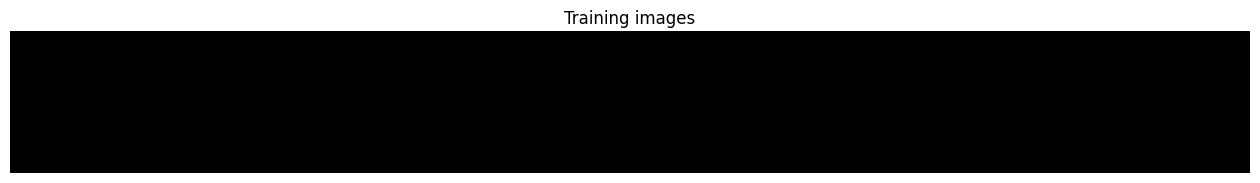

In [9]:
train_2_x = torch.from_numpy(twosDataset).float()
train_2_y = torch.from_numpy(twosIndex).long()

batch_size = 100

train_2 = torch.utils.data.TensorDataset(train_2_x, train_2_y)
train_loader_2 = torch.utils.data.DataLoader(train_2, batch_size=batch_size, shuffle=True)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

real_batch = next(iter(train_loader_2))
print(real_batch[0][0].shape)

print(real_batch[0].shape)

visualize_real = real_batch[0].reshape(100, 1, 16, -1)
print(visualize_real.shape)

real_test_img = vutils.make_grid(visualize_real)



# real_test_img = vutils.make_grid(real_batch[0][0].permute(1, 0, 2, 3))
print(real_test_img.shape)
# Permute - Moves the channel to the end as imshow expects
real_test_img = real_test_img.permute(1,2,0).numpy()
print(real_test_img.shape)

plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training images")
plt.imshow(real_test_img)
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0][0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
for index in range(2):
  for i, data in enumerate(train_loader_2, 0):
    print(len(data))

In [10]:
zVector = 200
num_output = 1
# number of features for feature map of generator
ngf = 64

# number of features for feature map of discriminator
ndf = 64

# Number of input channels to discriminator
ndc = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

num_epochs = 5

# Generator

In [11]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.conv_layer_1 = self._conv_layer_set(zVector, ngf * 8, 4, 1, padding=(1,1,1))
    self.conv_layer_2 = self._conv_layer_set(ngf * 8, ngf * 4, 4, 2, padding=(1,1,1))
    # self.conv_layer_3 = self._conv_layer_set(ngf * 4, 1, 4, 2, 1)
    self.conv_layer_3 = self._conv_layer_set(ngf * 4, ngf*2, 4, 2, padding=(1,1,1))
    self.conv_layer_4 = self._conv_layer_set(ngf * 2, 1, 4, 2, padding=(1,1,1))
    # self.conv_layer_4 = self._conv_layer_set(ngf*2, ngf, 4, 2, 1)
    # self.conv_layer_5 = self._conv_layer_set(ngf, 3, 4, 2, 1)
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()


  def _conv_layer_set(self, in_c, out_c, kernel_size, stride, padding):
    conv_layer = nn.Sequential(
        nn.ConvTranspose3d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm3d(out_c),
        # nn.ReLU(True)
        nn.LeakyReLU(0.2, inplace=True)
    )
    return conv_layer


  def forward(self, x):
    out = x.view(-1, zVector, 1,1,1)
    out = self.conv_layer_1(out)
    out = self.conv_layer_2(out)
    out = self.conv_layer_3(out)
    out = self.conv_layer_4(out)
    # out = self.conv_layer_5(out)
    # out = self.sigmoid(out)
    out = self.tanh(out)
    return out


In [12]:
generator = Generator().to(device)
summary(generator, input_size=([200]))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 16, 16, 16]        --
├─Sequential: 1-1                        [1, 512, 2, 2, 2]         --
│    └─ConvTranspose3d: 2-1              [1, 512, 2, 2, 2]         6,553,600
│    └─BatchNorm3d: 2-2                  [1, 512, 2, 2, 2]         1,024
│    └─LeakyReLU: 2-3                    [1, 512, 2, 2, 2]         --
├─Sequential: 1-2                        [1, 256, 4, 4, 4]         --
│    └─ConvTranspose3d: 2-4              [1, 256, 4, 4, 4]         8,388,608
│    └─BatchNorm3d: 2-5                  [1, 256, 4, 4, 4]         512
│    └─LeakyReLU: 2-6                    [1, 256, 4, 4, 4]         --
├─Sequential: 1-3                        [1, 128, 8, 8, 8]         --
│    └─ConvTranspose3d: 2-7              [1, 128, 8, 8, 8]         2,097,152
│    └─BatchNorm3d: 2-8                  [1, 128, 8, 8, 8]         256
│    └─LeakyReLU: 2-9                    [1, 128, 8, 8, 8] 

# Discriminator

In [13]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.conv_layer_1 = self._conv_layer_set(1, ndf, 4, 2, 1)
    self.conv_layer_2 = self._conv_layer_set(ndf, ndf*2, 4, 2, 1)
    self.conv_layer_3 = self._conv_layer_set(ndf*2, ndf*4, 4, 2, 1)
    self.conv_layer_4 = self._conv_layer_set(ndf*4, 1, 4, 2, 1)
    self.sigmoid = nn.Sigmoid()


  def _conv_layer_set(self, in_c, out_c, kernel_size, stride, padding):
    conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        # nn.Dropout(),
        # nn.AdaptiveAvgPool3d(out_c),
        # F.avg_pool3d(),
        # nn.AvgPool3d(1),
        nn.BatchNorm3d(out_c),
        # nn.ReLU()
        nn.LeakyReLU(0.2, inplace=True)
    )
    return conv_layer


  def forward(self, x):
    # out = x.view(-1, 3, 16, 16, 16)
    out = self.conv_layer_1(x)
    out = self.conv_layer_2(out)
    out = self.conv_layer_3(out)
    out = self.conv_layer_4(out)
    # out = out.mean(dim=[2, 3, 4], keepdim=True) # Global average pooling
    out = out.view(out.size(0), -1)
    # out = self.fc_layer(out)
    out = self.sigmoid(out)
    return out


In [14]:
discriminator = Discriminator().to(device)
summary(discriminator, input_size=(1, 1, 16, 16, 16))
# The output from the discriminator is a probability (confidence) of whether the input is real
# So, if it is low then that means it thinks the input is fake

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 8, 8, 8]          --
│    └─Conv3d: 2-1                       [1, 64, 8, 8, 8]          4,096
│    └─BatchNorm3d: 2-2                  [1, 64, 8, 8, 8]          128
│    └─LeakyReLU: 2-3                    [1, 64, 8, 8, 8]          --
├─Sequential: 1-2                        [1, 128, 4, 4, 4]         --
│    └─Conv3d: 2-4                       [1, 128, 4, 4, 4]         524,288
│    └─BatchNorm3d: 2-5                  [1, 128, 4, 4, 4]         256
│    └─LeakyReLU: 2-6                    [1, 128, 4, 4, 4]         --
├─Sequential: 1-3                        [1, 256, 2, 2, 2]         --
│    └─Conv3d: 2-7                       [1, 256, 2, 2, 2]         2,097,152
│    └─BatchNorm3d: 2-8                  [1, 256, 2, 2, 2]         512
│    └─LeakyReLU: 2-9                    [1, 256, 2, 2, 2]         

In [15]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
generator.apply(weights_init)

Generator(
  (conv_layer_1): Sequential(
    (0): ConvTranspose3d(200, 512, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_layer_2): Sequential(
    (0): ConvTranspose3d(512, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_layer_3): Sequential(
    (0): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_layer_4): Sequential(
    (0): ConvTranspose3d(128, 1, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
  

In [17]:
discriminator.apply(weights_init)

Discriminator(
  (conv_layer_1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_layer_2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_layer_3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_layer_4): Sequential(
    (0): Conv3d(256, 1, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(1, eps=1e-05, mome

## Loss & Optimizers

In [18]:
lr = 0.02
num_epochs = 10
D_lr = 0.02
G_lr = 0.02

In [19]:
def wasserstein_loss(y_true, y_pred):
  return y_true.mean() * y_pred.mean()



# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# criterion_d = nn.MSELoss()
criterion_d = nn.BCELoss()
# criterion_d = wasserstein_loss()

# criterion_g = nn.L1Loss()
criterion_g = nn.BCELoss()


# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(100, zVector, 1, 1, 1, device=device)
print(fixed_noise.shape)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
# fake_label = -1.

# Setup Adam optimizers for both G and D
optimizerD = Adam(discriminator.parameters(), lr=D_lr, betas=(beta1, 0.999))
# optimizerD = torch.optim.SGD(discriminator.parameters(), lr=D_lr)
optimizerG = Adam(generator.parameters(), lr=G_lr, betas=(beta1, 0.999))

torch.Size([100, 200, 1, 1, 1])


## Training

In [20]:

img_list = []
depth_slice_list = []
G_losses = []
D_losses = []
D_fake_loss = []
D_real_loss = []
iters = 0
D_real_output = []
D_fake_output = []

D_initial_real_weights = []
D_updated_real_weights = []

D_real_accuracy = []
D_fake_accuracy = []

def calculate_accuracy(outputs, labels):
  correct = 0
  for i in range(0, len(outputs)):
    if(labels[0] == 1):
      if (outputs[i] > 0.5):
        correct += 1

    elif(labels[0] == 0):
      if(outputs[i] < 0.5):
        correct += 1

  # predictions = (outputs > 0.5).float()
  # correct = (predictions == labels).float()
  # accuracy = correct.mean().item
  # return accuracy()
  return correct


# Label smoothing according to GANHACKS
def soft_label(label_type):
  if(label_type == "real"):
    val = random.uniform(0.7, 1.2)
    return val
  elif(label_type == "fake"):
    val = random.uniform(0.0, 0.3)
    return val


print("Starting training loop")
# For each epoch
for epoch in range (num_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(train_loader, 0):

# Train with all-real batch
    discriminator.zero_grad()
    # optimizerD.zero_grad()
  # Format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # label = torch.full((b_size,), soft_label("real"), dtype=torch.float, device=device)
  # Forward pass real batch through D
    output = discriminator(real_cpu).view(-1)

    real_accuracy = calculate_accuracy(output, label)
    D_real_accuracy.append(real_accuracy)

    D_real_output.append(output)
  # Calculate loss on all-real batch
    errD_real = criterion_d(output, label)
    # errD_real = wasserstein_loss(output, label)
    D_real_loss.append(errD_real.item())
  # Calculate gradients for D in backward pass
    errD_real.backward()

  # Represents how confident the discriminator is when classifying real data
    D_x = output.mean().item()
    # D_x = output.mean()

  # Wass loss (part 1) - avg output from real data
    # D_x.backward()



# Train D with all-fake batch
  # Generate batch of latent vectors
    noise = torch.randn(b_size, zVector, 1, 1, 1, device=device)
    # print(noise.shape)
  # Generate fake image batch with G
    fake = generator(noise)
    label.fill_(fake_label)
    # label = torch.full((b_size,), soft_label("fake"), dtype=torch.float, device=device)
  # Classify all fake batch with D
    output = discriminator(fake.detach()).view(-1)
    D_fake_output.append(output)
  # Calculate D's loss on all fake-batch
    errD_fake = criterion_d(output, label)
    # errD_fake = wasserstein_loss(output, label)

    fake_accuracy = calculate_accuracy(output, label)
    D_fake_accuracy.append(fake_accuracy)

    D_fake_loss.append(errD_fake.item())
  # Calculate gradients for this batch, accumulated (summed - no zero out) with previous gradients
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # D_G_z1 = output.mean()*-1
    # D_G_z1.backward()
  # Compute error of D as sum over the fake and real batches
    errD = errD_real + errD_fake
    # errD = D_x - D_G_z1
    # errD = errD_real - errD_fake - (Wasserstyein)
    # errD = errD / 2
  # Update D
    # if(errD > 1.35):
    optimizerD.step()

# Update generator
    generator.zero_grad()
    # optimizerG.zero_grad()
  # Fake lables are real for generator cost
    # label = torch.full((b_size,), soft_label("real"), dtype=torch.float, device=device)
    label.fill_(real_label)
  # Since D was just updated, perform another forward pass of all fake-batch through D
    output = discriminator(fake).view(-1)
  # Calculate G's loss based on this output
    errG = criterion_g(output, label)
  # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # D_G_z2 = output.mean()*-1
    # D_G_z2.backward()
  # Update G
    optimizerG.step()

    if i % 50 == 0:
      print(f"Epoch: {epoch} / {num_epochs}")
      print(f"I {i}")
      # print(len(train_loader_2))
      print(f"ErrD {errD}")
      print(f"ErrG {errG}")
      print(f"D real output: {D_x}")
      print(f"D fake output: {D_G_z1} / {D_G_z2}")
      print(f"ErrD real: {errD_real}")
      print(f"ErrD fake: {errD_fake}")


    G_losses.append(errG.item())
    D_losses.append(errD.item())

    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
      with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
        img_list.append(fake)
        depth_slice = fake[0, :, 8, :, :]
        depth_slice_list.append(depth_slice)
      # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
      # img_list.append(vutils.make_grid(depth_slice, padding=2, normalize=True))


    iters += 1


Starting training loop
Epoch: 0 / 10
I 0
ErrD 1.501007318496704
ErrG 0.6078464984893799
D real output: 0.5652013421058655
D fake output: 0.5683532357215881 / 0.5584592223167419
ErrD real: 0.5963113903999329
ErrD fake: 0.9046958684921265
Epoch: 0 / 10
I 50
ErrD 1.3882629871368408
ErrG 0.7138914465904236
D real output: 0.4920477271080017
D fake output: 0.4887814521789551 / 0.49237218499183655
ErrD real: 0.7138679623603821
ErrD fake: 0.674394965171814
Epoch: 1 / 10
I 0
ErrD 1.3552699089050293
ErrG 0.7380596995353699
D real output: 0.5000251531600952
D fake output: 0.47918418049812317 / 0.4790220260620117
ErrD real: 0.7013306021690369
ErrD fake: 0.6539393663406372
Epoch: 1 / 10
I 50
ErrD 1.3878083229064941
ErrG 0.7409600615501404
D real output: 0.4894946217536926
D fake output: 0.4832594692707062 / 0.47862640023231506
ErrD real: 0.7222545742988586
ErrD fake: 0.6655537486076355
Epoch: 2 / 10
I 0
ErrD 1.3604294061660767
ErrG 0.7631670832633972
D real output: 0.48972198367118835
D fake output

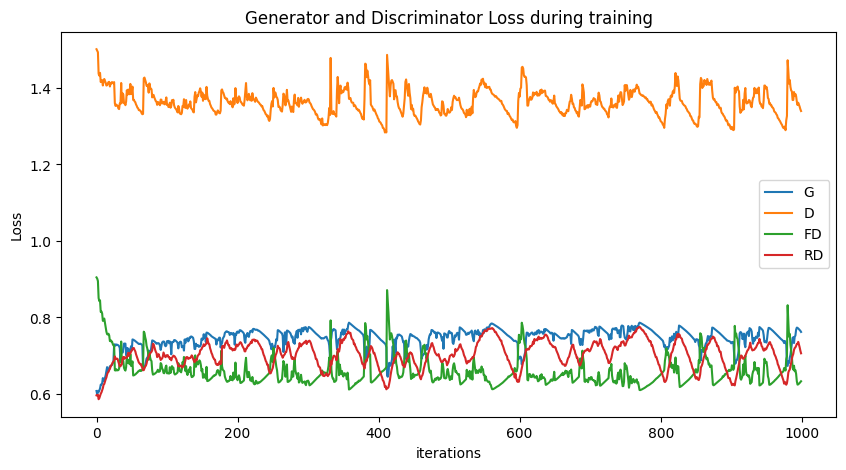

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss during training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.plot(D_fake_loss, label="FD")
plt.plot(D_real_loss, label="RD")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

[45, 44, 43, 50, 48, 50, 50, 50, 50, 50, 49, 50, 50, 50, 50, 50, 50, 50, 49, 49, 48, 49, 48, 48, 46, 45, 35, 32, 32, 29, 32, 37, 41, 39, 41, 43, 39, 29, 27, 36, 37, 33, 27, 35, 39, 36, 33, 31, 27, 28, 32, 28, 24, 21, 22, 28, 25, 30, 28, 29, 32, 28, 32, 33, 35, 32, 37, 39, 39, 37, 36, 37, 37, 39, 39, 35, 34, 31, 30, 29, 13, 18, 19, 23, 25, 27, 29, 23, 28, 30, 32, 32, 33, 29, 28, 30, 31, 31, 27, 23, 30, 34, 32, 28, 31, 33, 34, 34, 29, 32, 31, 34, 27, 30, 35, 38, 36, 30, 34, 37, 28, 37, 34, 36, 38, 38, 40, 39, 34, 35, 36, 33, 32, 32, 28, 30, 31, 32, 34, 32, 33, 34, 35, 39, 40, 35, 31, 31, 33, 27, 32, 30, 26, 25, 26, 28, 22, 10, 17, 22, 23, 22, 25, 24, 26, 23, 30, 27, 26, 29, 29, 31, 37, 38, 34, 31, 34, 35, 24, 27, 30, 25, 27, 23, 21, 22, 22, 24, 21, 24, 21, 23, 25, 28, 19, 30, 26, 28, 16, 20, 26, 25, 26, 21, 24, 23, 24, 24, 23, 27, 22, 23, 23, 23, 27, 26, 19, 18, 20, 24, 17, 18, 16, 15, 18, 18, 20, 19, 15, 19, 22, 20, 22, 23, 20, 24, 26, 28, 26, 27, 31, 31, 32, 32, 39, 38, 35, 36, 38, 34,

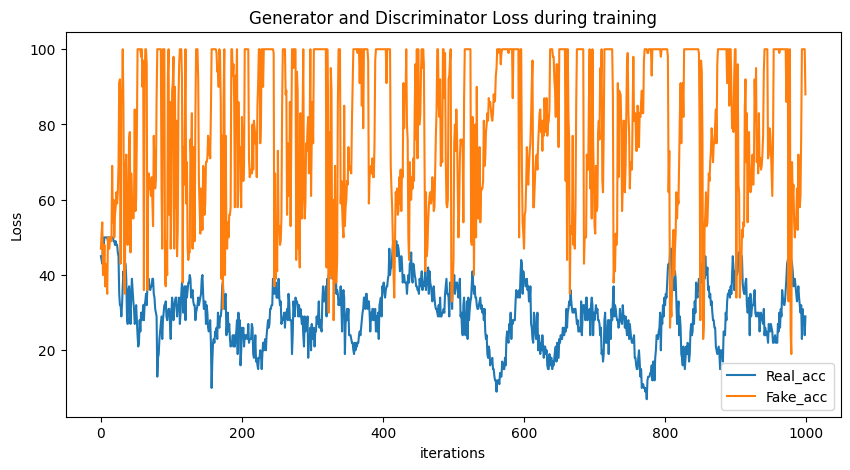

In [22]:
print(D_real_accuracy)
print(D_fake_accuracy)
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss during training")
# plt.plot(G_losses, label="G")
# plt.plot(D_losses, label="D")
# plt.plot(D_fake_loss, label="FD")
# plt.plot(D_real_loss, label="RD")
plt.plot(D_real_accuracy, label="Real_acc")
plt.plot(D_fake_accuracy, label="Fake_acc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
print(D_real_output[9])
print(len(D_real_output[30]))

tensor([0.5459, 0.5805, 0.4840, 0.7070, 0.4035, 0.7613, 0.3712, 0.5973, 0.5844,
        0.6857, 0.7499, 0.7469, 0.5846, 0.7093, 0.4553, 0.6383, 0.3547, 0.4990,
        0.4479, 0.7426, 0.4705, 0.6921, 0.4830, 0.4864, 0.3947, 0.7520, 0.6530,
        0.7522, 0.3927, 0.4945, 0.4548, 0.6205, 0.6865, 0.5400, 0.6138, 0.4481,
        0.3805, 0.4888, 0.5674, 0.6291, 0.5188, 0.5344, 0.6541, 0.7656, 0.4968,
        0.6597, 0.3897, 0.4887, 0.4770, 0.6883, 0.7324, 0.6857, 0.5432, 0.5939,
        0.4806, 0.6513, 0.4934, 0.6759, 0.4197, 0.6229, 0.4910, 0.5277, 0.5842,
        0.6855, 0.5522, 0.7137, 0.5417, 0.4937, 0.5619, 0.5934, 0.5641, 0.7770,
        0.4141, 0.4951, 0.7159, 0.7892, 0.4241, 0.5171, 0.4295, 0.7676, 0.4205,
        0.5599, 0.7547, 0.4909, 0.5329, 0.4983, 0.4889, 0.5743, 0.3891, 0.5434,
        0.4112, 0.4711, 0.4580, 0.4936, 0.6706, 0.6863, 0.4488, 0.5917, 0.6120,
        0.5891], device='cuda:0', grad_fn=<ViewBackward0>)
100


In [23]:
print(D_fake_output[49])

tensor([0.4537, 0.4459, 0.5286, 0.5221, 0.4544, 0.5266, 0.4529, 0.4498, 0.4567,
        0.4528, 0.5275, 0.4973, 0.4538, 0.4544, 0.5267, 0.4806, 0.5383, 0.5270,
        0.4471, 0.4718, 0.4596, 0.5152, 0.4997, 0.5327, 0.4559, 0.5250, 0.5242,
        0.5287, 0.4539, 0.4468, 0.5201, 0.5323, 0.5245, 0.4534, 0.5439, 0.4613,
        0.4538, 0.4534, 0.5190, 0.5348, 0.4550, 0.4555, 0.4544, 0.5244, 0.5274,
        0.4536, 0.5486, 0.4563, 0.4459, 0.4516, 0.4724, 0.5194, 0.4605, 0.4512,
        0.4555, 0.5265, 0.4502, 0.5562, 0.4481, 0.5241, 0.4454, 0.4572, 0.4516,
        0.5150, 0.4495, 0.5452, 0.4464, 0.4677, 0.5292, 0.4544, 0.4510, 0.5340,
        0.5447, 0.5170, 0.4564, 0.4521, 0.4541, 0.4566, 0.5417, 0.4668, 0.5528,
        0.5100, 0.5208, 0.5262, 0.4607, 0.4495, 0.4542, 0.4519, 0.5439, 0.5304,
        0.4518, 0.4483, 0.5569, 0.4625, 0.4537, 0.4502, 0.5501, 0.5299, 0.5418,
        0.5367], device='cuda:0', grad_fn=<ViewBackward0>)


In [ ]:
|for i in range(0,100):
  t = D_fake_output[i]
  print ((t == 0.4).nonzero(as_tuple=True)[0])

In [ ]:
img_list[0][0][0][0]

In [24]:
for index in range(60, 64):
  plot_img_3d = np.squeeze(img_list[0][index])
  print(img_list[0].shape)

  plot_data = []
  for x in range(16):
    for y in range(16):
      for z in range(16):
        val = int(plot_img_3d[x,y,z] * 255)
        plot_data.append([x, y, z, val])


  plot_df = pd.DataFrame(plot_data, columns=["x", 'y', 'z', 'val'])
  print(plot_df.describe())
  plot_df = plot_df.loc[plot_df['val'] > 127]

  fig = go.Figure(data=[go.Scatter3d(x=plot_df['x'], y=plot_df['y'], z=plot_df['z'],
                                     mode='markers',
                                    #  text=f"current label: {plot_label.nonzero()[0][0]}",
                                     marker=dict(
                                     color=[f'rgb({c}, {c}, {c})' for c in plot_df['val']],
                                     size=6,
                                     colorscale="Viridis",
                                     opacity=0.7))])
  fig.show()

torch.Size([100, 1, 16, 16, 16])
                 x            y            z          val
count  4096.000000  4096.000000  4096.000000  4096.000000
mean      7.500000     7.500000     7.500000    38.820801
std       4.610335     4.610335     4.610335    98.720909
min       0.000000     0.000000     0.000000  -187.000000
25%       3.750000     3.750000     3.750000   -22.000000
50%       7.500000     7.500000     7.500000    -8.000000
75%      11.250000    11.250000    11.250000   105.000000
max      15.000000    15.000000    15.000000   254.000000


torch.Size([100, 1, 16, 16, 16])
                 x            y            z          val
count  4096.000000  4096.000000  4096.000000  4096.000000
mean      7.500000     7.500000     7.500000    39.132324
std       4.610335     4.610335     4.610335    99.246490
min       0.000000     0.000000     0.000000  -194.000000
25%       3.750000     3.750000     3.750000   -22.000000
50%       7.500000     7.500000     7.500000    -9.000000
75%      11.250000    11.250000    11.250000   107.250000
max      15.000000    15.000000    15.000000   254.000000


torch.Size([100, 1, 16, 16, 16])
                 x            y            z          val
count  4096.000000  4096.000000  4096.000000  4096.000000
mean      7.500000     7.500000     7.500000    38.372559
std       4.610335     4.610335     4.610335    98.627452
min       0.000000     0.000000     0.000000  -194.000000
25%       3.750000     3.750000     3.750000   -22.000000
50%       7.500000     7.500000     7.500000    -9.000000
75%      11.250000    11.250000    11.250000   105.000000
max      15.000000    15.000000    15.000000   254.000000


torch.Size([100, 1, 16, 16, 16])
                 x            y            z          val
count  4096.000000  4096.000000  4096.000000  4096.000000
mean      7.500000     7.500000     7.500000    38.173828
std       4.610335     4.610335     4.610335    98.008096
min       0.000000     0.000000     0.000000  -188.000000
25%       3.750000     3.750000     3.750000   -22.000000
50%       7.500000     7.500000     7.500000    -9.000000
75%      11.250000    11.250000    11.250000   101.250000
max      15.000000    15.000000    15.000000   254.000000


torch.Size([3, 16, 16, 16])


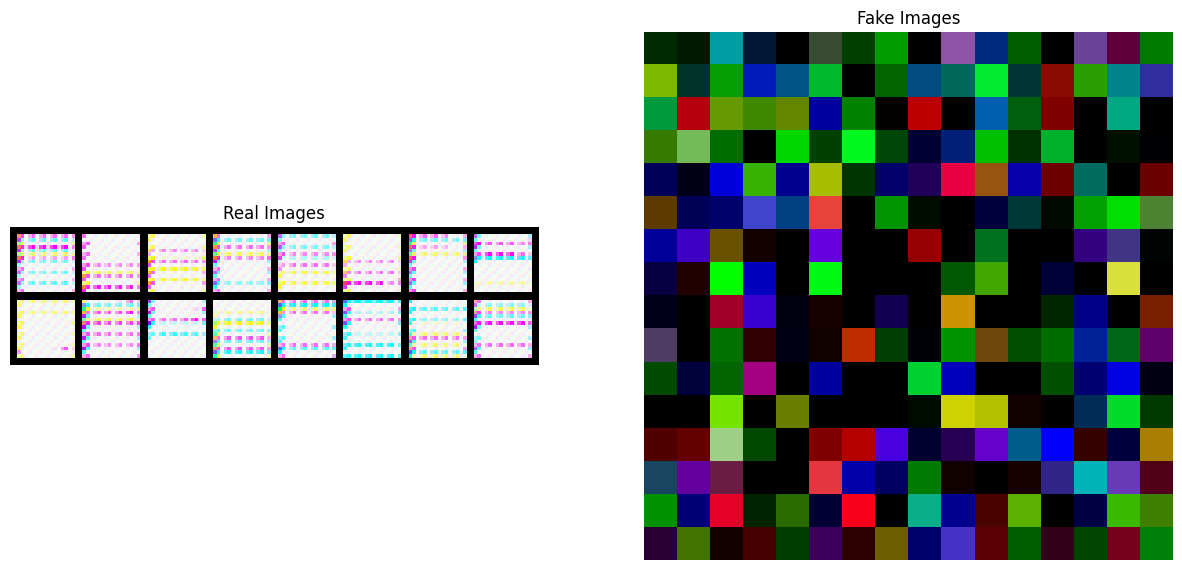

In [ ]:
real_batch = next(iter(train_loader_2))

plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
print(real_batch[0][0].shape)
real_test_img = vutils.make_grid(real_batch[0][0].permute(1, 0, 2, 3))
real_test_img = real_test_img.permute(1,2,0).numpy()
plt.imshow(real_test_img)

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))


In [ ]:
from plotly.subplots import make_subplots
print(real_batch[0][0].shape)
sample_object = real_batch[0][0]

x_all = []
y_all = []
z_all = []

for channel in range(3):
  channel_data = sample_object[channel]

  x_all.extend(channel_data[:, :, 0].flatten())
  y_all.extend(channel_data[:, :, 1].flatten())
  z_all.extend(channel_data[:, :, 2].flatten())


print(channel_data.shape)
trace1 = go.Scatter3d(x=x_all, y=y_all, z=z_all, mode='markers', marker=dict(size=12, color=z_c, colorscale="Viridis", opacity=0.7))
data = [trace1]

layout = go.Layout(height=500, width=500)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

# fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]])
# for channel in range(3):
#   fig.add_trace(go.Surface(z=real_batch[0][0][channel], colorscale="Viridis"), row=1, col=channel + 1)


# fig.update_layout(title="3D Object visual")
# fig.update_layout(scene=dict(aspectmode="cube"))
# fig.show()

torch.Size([3, 16, 16, 16])
torch.Size([16, 16, 16])


In [ ]:
train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(targets_train).long()
test_x = torch.from_numpy(X_test).float()
test_y = torch.from_numpy(targets_test).long()

batch_size = 100

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(train_x, train_y)
test = torch.utils.data.TensorDataset(test_x, test_y)

# Data Loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle=False)

In [ ]:
num_classes = 10

# Create CNN Model
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    # What if we use stride 2 convolution?

    # Out channels are the number of features we are looking for
    # How do we find out the optimal number of output channels? - Trial and error initially ig
    self.conv_layer1 = self._conv_layer_set(3, 32)
    self.conv_layer2 = self._conv_layer_set(32, 64)
    # self.fc1 = nn.Linear(2**3*64, 128)
    # self.fc2 = nn.Linear(128, num_classes)
    # self.relu = nn.LeakyReLU()
    # self.batch = nn.BatchNorm1d(128)
    # self.drop=nn.Dropout(p=0.15)


    # TEST FOR KERNEL 5 X 5 X 5 ****************************************************

    self.fc1 = nn.Linear(64, 100)
    self.fc2 = nn.Linear(100, num_classes)
    self.relu = nn.LeakyReLU()
    self.batch = nn.BatchNorm1d(100)
    self.drop=nn.Dropout(p=0.15)

# **************************************************

  def _conv_layer_set(self, in_c, out_c):
    # What if we increase the kernel size from 3x3x3 to 5x5x5
    # so we are using more values to find the same # of features?
    conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(5,5,5), padding=0),
        nn.LeakyReLU(),
        # What if we took the average pool ?
          # The average pool is worse than MaxPool3d
            # Average pool - less sensitive to small variations. Max pool is more sensitive to small variations
            # This dataset is sensitive to small variations
          # Can work well when we have less spatial information and want to avoid overfitting
          # nn.AvgPool3d((2,2,2)) - PyTorch's version
        # Max Pool:
          # Replaces a group of elements with their maximum value
          # When you want to capture the most salient feature in a local region
          # When you want to retain the strongest response (maximum activation) from a group of features
          # Emphasize dominant features and discard less significant ones
          # Use case: Image Classification
        nn.MaxPool3d((2,2,2)),
    )
    return conv_layer


  def forward(self, x):
    # Set 1
    out = self.conv_layer1(x)
    out = self.conv_layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.batch(out)
    out = self.drop(out)
    out = self.fc2(out)

    return out



# Definition of hyperparameters
n_iters = 4500
num_epochs = n_iters / (len(train_x) / batch_size )
num_epochs = int(num_epochs)

# Create CNN
model = CNNModel()

if torch.cuda.is_available():
    model.cuda()


# model.eval()
# target_layer = model.conv_layer1

# dummy_input = torch.randn(100, 3, 16,16,16).cuda()
# activations = target_layer(dummy_input)
# feature_map_index = 0

# feature_map = activations[0, feature_map_index].detach().cpu().numpy()

# plt.imshow(feature_map[0], cmap="viridis")
# plt.title(f"Feature map")
# plt.colorbar()
# plt.show()


print(model)

error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)



In [ ]:
len(train_x)

10000

In [ ]:
summary(model, input_size=(batch_size, 3, 16, 16, 16))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 6, 6, 6]        --
│    └─Conv3d: 2-1                       [100, 32, 12, 12, 12]     12,032
│    └─LeakyReLU: 2-2                    [100, 32, 12, 12, 12]     --
│    └─MaxPool3d: 2-3                    [100, 32, 6, 6, 6]        --
├─Sequential: 1-2                        [100, 64, 1, 1, 1]        --
│    └─Conv3d: 2-4                       [100, 64, 2, 2, 2]        256,064
│    └─LeakyReLU: 2-5                    [100, 64, 2, 2, 2]        --
│    └─MaxPool3d: 2-6                    [100, 64, 1, 1, 1]        --
├─Linear: 1-3                            [100, 100]                6,500
├─LeakyReLU: 1-4                         [100, 100]                --
├─BatchNorm1d: 1-5                       [100, 100]                200
├─Dropout: 1-6                           [100, 100]                --
├─

In [ ]:
for name, param in model.named_parameters():
  if 'weight' in name:
    print(f"Layer: {name}, Shape: {param.shape}")

Layer: conv_layer1.0.weight, Shape: torch.Size([32, 3, 5, 5, 5])
Layer: conv_layer2.0.weight, Shape: torch.Size([64, 32, 5, 5, 5])
Layer: fc1.weight, Shape: torch.Size([100, 64])
Layer: fc2.weight, Shape: torch.Size([10, 100])
Layer: batch.weight, Shape: torch.Size([100])


In [ ]:
for name, param in model.named_parameters():
  if 'bias' in name:
    print(f"Layer: {name}, Shape: {param.shape}")

Layer: conv_layer1.0.bias, Shape: torch.Size([32])
Layer: conv_layer2.0.bias, Shape: torch.Size([64])
Layer: fc1.bias, Shape: torch.Size([100])
Layer: fc2.bias, Shape: torch.Size([10])
Layer: batch.bias, Shape: torch.Size([100])


In [ ]:
# CNN Model training
count = 0
loss_list = []
iteration_list = []
accuracy_list= []
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):


    train = Variable(images.view(100,3,16,16,16)).cuda()
    labels = Variable(labels).cuda()

    # Clear gradients
    optimizer.zero_grad()

    # Forward propagation
    outputs = model(train)

    # Calculate softmax and cross entropy loss
    loss = error(outputs, labels)

    # Calculating gradients
    loss.backward()

    # Update parameters
    optimizer.step()

    count += 1
    if count % 50 == 0:
      # Calculate accuracy
      correct = 0
      total = 0

      # Iterate through test dataset
      for images, labels in test_loader:

        test = Variable(images.view(100, 3, 16,16,16)).cuda()

        # Forward propagation
        outputs = model(test)

        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]

        # Total number of labels
        total += len(labels)
        correct += (predicted == labels.cuda()).sum()


      accuracy = 100 * correct / float(total)

      # Store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if count % 500 == 0:
      # Print loss
      print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500 Loss: 1.6488327980041504 Accuracy: 39.95000076293945 %
Iteration: 1000 Loss: 1.3786159753799438 Accuracy: 47.750003814697266 %
Iteration: 1500 Loss: 1.1686598062515259 Accuracy: 52.70000076293945 %
Iteration: 2000 Loss: 0.9449993968009949 Accuracy: 55.35000228881836 %
Iteration: 2500 Loss: 0.8408153057098389 Accuracy: 57.150001525878906 %
Iteration: 3000 Loss: 0.6617785692214966 Accuracy: 58.750003814697266 %
Iteration: 3500 Loss: 0.5693461894989014 Accuracy: 58.150001525878906 %
Iteration: 4000 Loss: 0.4773353636264801 Accuracy: 58.000003814697266 %
Iteration: 4500 Loss: 0.3476225733757019 Accuracy: 58.150001525878906 %


In [ ]:
# import plotly.express as px
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode

In [ ]:
pointsHf = h5py.File("./train_point_clouds.h5", "r")
digits = []
digitIndex = 1
for i in range(10):
  digit = (
      pointsHf[str(i)]["img"][:],
      pointsHf[str(i)]["points"][:],
      pointsHf[str(i)].attrs["label"]
      )
  digits.append(digit)


x_c = [r[0] for r in digits[digitIndex][1]]
y_c = [r[1] for r in digits[digitIndex][1]]
z_c = [r[2] for r in digits[digitIndex][1]]

print(len(x_c))
print(x_c[0])

trace1 = go.Scatter3d(x=x_c, y=y_c, z=z_c, mode='markers', marker=dict(size=12, color=z_c, colorscale="Viridis", opacity=0.7))
data = [trace1]

layout = go.Layout(height=500, width=600, title="Digit: " + str(digits[digitIndex ][2]))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

26200
0.1499999999999951
